# Deep Learning with MNIST
This is an example of using Keras to detect handwritten characters in the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).
The data has been downloaded from the corresponding [Kaggle competition](https://www.kaggle.com/c/digit-recognizer). It consists of 28x28 pixel grayscale images of single handwritten digits from 0 to 9. The goal is to maximize the accuracy with which digits are recognized.

A broad outline of the solution is:
- augmenting data by applying rotation, shift and zoom
- training CNNs with various parameters for a few epochs to compare their performance
- training the best of these CNNs until convergence
- creating a submission on the test set

Performance on the test set will be ~0.992 in the end.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.style as matplot_style
matplot_style.use('ggplot')

# image size 784 (28x28)
height = 28
width = 28

# Load data
Load the data with pandas and check out some general statistics. There are 42k train and 28k test images in the Kaggle version of this dataset, i.e., a total of 70k images. Note that this is different from the literature, where the split is usually 60k train and 10k test images (e.g., [LeCun et. al 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf))

As expected, we find 10 different labels (digits from 0 to 9) which are evenly distributed.

In [2]:
train = pd.read_csv("../data/train.csv").values
test = pd.read_csv("../data/test.csv").values

In [3]:
labels = train[:,0]

train = train[:,1:].reshape(train.shape[0], height, width)
test = test.reshape(test.shape[0], height, width)

num_classes = np.unique(labels).shape[0]

print("Train:     {}".format(train.shape))
print("Test:      {}".format(test.shape))
print("Labels:    {}".format(labels.shape))
print("# Classes: {}".format(num_classes))

Train:     (42000, 28, 28)
Test:      (28000, 28, 28)
Labels:    (42000,)
# Classes: 10


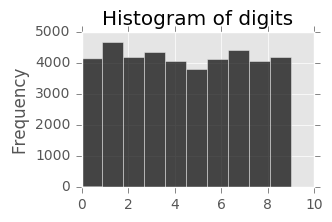

In [4]:
pd.DataFrame(data=labels).plot.hist(alpha=0.7, bins=num_classes, color='k', figsize=(3, 2), legend=False).set_title('Histogram of digits')

# Visualize some of the numbers and their labels
Let's see what the images look like by plotting a couple of them. Below, we can see images with their true labels shown above.

In [5]:
def display_multiple(data, labels, indexes):
    num_digits = len(indexes)
    num_cols = 10
    num_rows = (num_digits / num_cols) + (0 if num_digits % num_cols == 0 else 1)
    fig = plt.figure(figsize=(10, 10))
    
    for i, idx in enumerate(indexes):
        plt.subplot(num_rows, num_cols, i+1)
        display(data, labels, idx)
    plt.tight_layout()
    plt.show()

def display(data, labels, idx):
    plt.title(labels[idx]) if labels is not None else plt.title("?")
    image = data[idx].squeeze()
    plt.axis('off')
    plt.imshow(image, cmap=cm.binary)

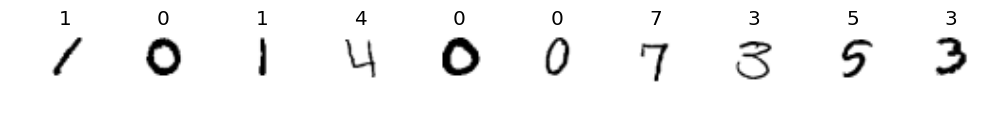

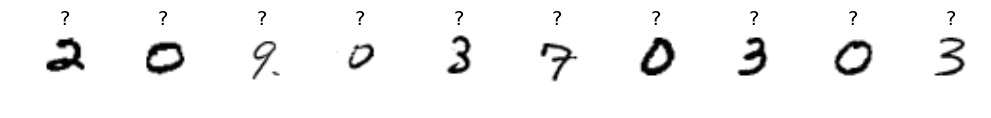

In [6]:
display_multiple(train, labels, range(10))
display_multiple(test, None, range(10))

# Encode labels one-hot
Classfication with Keras requires labels to be one-hot encoded. Let's create a helper for that and verfiy that it works as expected.

In [7]:
def get_dummies(labels, num_classes=None):
    num_labels = labels.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_dummies = np.zeros((num_labels, num_classes))
    labels_dummies.flat[index_offset + labels.ravel()] = 1
    return labels_dummies

In [8]:
labels_dummies = get_dummies(labels, num_classes)

In [9]:
for idx in range(10):
    print("Label: {} encoded as {}".format(labels[idx], labels_dummies[idx]))

Label: 1 encoded as [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Label: 0 encoded as [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Label: 1 encoded as [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Label: 4 encoded as [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Label: 0 encoded as [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Label: 0 encoded as [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Label: 7 encoded as [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Label: 3 encoded as [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Label: 5 encoded as [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Label: 3 encoded as [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


# Split train data into train/validation sets
To tune the network architecture, we split the train data into our final train set and a validation set. We use 80% (33.6k) for training and 20% (8.4k) for validation.

To prepare the images for using them with Keras on TensorFlow, we further reshape our datasets to (n, 28, 28, 1) and divide by 255 for get pixel values in range [0,1].

We further shuffle the data to be 100% sure they are not in order (but Keras will do it for us in every epoch too, so it's not strictly necessary).

In [10]:
# shuffle train images, just to be sure
np.random.seed(42)

permutation = np.random.permutation(train.shape[0])

split = 0.8
split_idx = int(train.shape[0] * split)

train_images = train[permutation][:split_idx]
validation_images = train[permutation][split_idx:]

train_labels = labels[permutation][:split_idx]
validation_labels = labels[permutation][split_idx:]

Train size:      (33600, 28, 28)
Validation size: (8400, 28, 28)


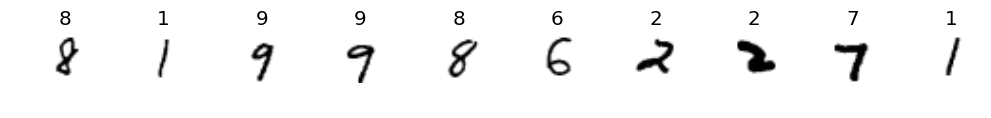

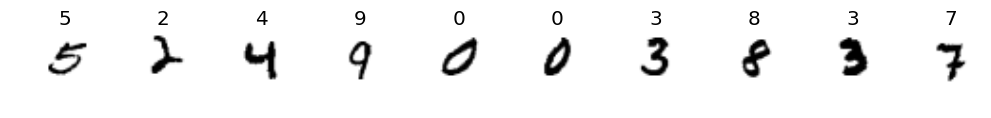

In [11]:
# Verify data and labels are shuffeled correctly
print("Train size:      {}".format(train_images.shape))
print("Validation size: {}".format(validation_images.shape))
display_multiple(train_images, train_labels, range(10))
display_multiple(validation_images, validation_labels, range(10))

In [12]:
input_shape = (height, width, 1) # grayscale image in tf dim ordering

def prepare_data_for_keras(train_images, validation_images):
    X_train = train_images.reshape(train_images.shape[0], *input_shape).astype('float32') / 255
    X_val = validation_images.reshape(validation_images.shape[0], *input_shape).astype('float32') / 255
    return X_train, X_val

In [13]:
X_train, X_val = prepare_data_for_keras(train_images, validation_images)
y_train, y_val = get_dummies(train_labels, num_classes), get_dummies(validation_labels, num_classes)

# Augment training data

It is good practice to apply transformations to image processing networks to make them more robust. For the MNIST problem, we can expect at least the following challenges in a real-world application:
- the digits are not properly cropped and thus not in the center of the image --> apply random shifts
- the digits may be of different sizes, either due to different persons writing them or to the margin used when cropping --> apply random zooms
- the digits are skewed, e.g., because the person writing them likes to write this way --> apply random rotations 

Many more problems are conceivable. For instance, people may use a very thick pen. You could simulate that by blurring out black areas of the images or, alternatively, apply [thinning algorithms](http://answers.opencv.org/question/3207/what-is-a-good-thinning-algorithm-for-getting-the-skeleton-of-characters-for-ocr/) to make the digits clearer. However, we only use the very simple methods described above for now.

We augment the train dataset to 4x it's original size below:

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.05,
                             width_shift_range=0.25,
                             height_shift_range=0.25,
                             rotation_range=45)
datagen.fit(X_train)

Using TensorFlow backend.


In [15]:
num_new_data = X_train.shape[0] * 3 # 100800 images

new_X_train = []
new_y_train = []
num_images_created = 0
batch_size = 100
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
    new_X_train.append(X_batch)
    new_y_train.append(y_batch)
    num_images_created += batch_size
    if num_images_created % 10000 == 0:
        print("{} done".format(num_images_created))
    if num_images_created >= num_new_data:
        break

new_X_train = np.vstack(new_X_train)
new_y_train = np.vstack(new_y_train)
print("New data:   {}".format(new_X_train.shape))
print("New labels: {}".format(new_y_train.shape))

10000 done
20000 done
30000 done
40000 done
50000 done
60000 done
70000 done
80000 done
90000 done
100000 done
New data:   (100800, 28, 28, 1)
New labels: (100800, 10)


In [16]:
X_train = np.vstack([X_train, new_X_train])
y_train = np.vstack([y_train, new_y_train])
print("Augmentated image dataset: {}".format(X_train.shape))
print("Augmentated labels:        {}".format(y_train.shape))

Augmentated image dataset: (134400, 28, 28, 1)
Augmentated labels:        (134400, 10)


# Build a model and define parameter space
Like most people, we use a [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) style model for MNIST. It has two convolutional layers followed by a dense layer followed by softmax.

We define a model builder below that takes some parameters:
- `num_filters`: number of filters in the convolutional layers
- `kernel_size`: size of the filter window in the convolutional layers
- `pool_size`: size of the max pooling windows applied after convolutional layers
- `dense_size`: number of nodes in the dense layer

Other parameters are hardwirred for simplicity. We apply dropout to avoid overfitting and rectified linear units as activation functions.

We then define a configuration space to search in. It is chosen based on what others usually use on MNIST. For this example, we only vary `num_filters`, `kernel_size` and `dense_size`.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
tf.python.control_flow_ops = tf # hack to get latest tensorflow version to work with keras

def build_model(num_filters, kernel_size, pool_size, dense_size):
    model = Sequential()
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model

In [18]:
num_filters_range = [32, 64, 96]
kernel_size_range = [(3, 3), (5, 5)]
pool_size_range = [(2, 2)]
dense_size_range = [128, 256, 512, 1024]
configurations = []
best_model = None
for num_filters in num_filters_range:
    for kernel_size in kernel_size_range:
        for pool_size in pool_size_range:
            for dense_size in dense_size_range:
                configurations.append((num_filters, kernel_size, pool_size, dense_size))

# Fit model
We fit a model in two steps:
- First, we try all configurations but train only for a few epochs to save computational resources (3 epochs in this case). Inspecting the results allows selecting the most promising model. 
- Then, we train the model we identified for more iterations until we can be sure it converged. 

All results are cached to be able to start and stop training without loosing anything. 

In [19]:
import pickle
import os
from collections import defaultdict

# prepare temp dir for results
if not os.path.exists('../cache/notebook'):
    os.makedirs('../cache/notebook')

accuracies_file = '../cache/notebook/accuracies.p'
histories_file = '../cache/notebook/histories.p'
best_model_file = '../cache/notebook/best_model.h5'

# create named function since you can't pickle lambdas
def named_none():
    return None

if os.path.exists(accuracies_file):
    accuracies = pickle.load(open(accuracies_file, "rb"))
else:
    accuracies = defaultdict(named_none)
    accuracies['highest'] = 0

if os.path.exists(histories_file):
    histories = pickle.load(open(histories_file, "rb"))
else:
    histories = defaultdict(named_none)

In [20]:
def train_model(X_train, y_train, X_val, y_val, num_filters, kernel_size, pool_size, dense_size):
    model = build_model(num_filters, kernel_size, pool_size, dense_size)
    result = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
                       verbose=1, validation_data=(X_val, y_val))
    accuracy = result.history['val_acc'][-1]
    history = result.history
    print("Trainin done... Accuracy: {}".format(accuracy))
    return model, accuracy, history

In [21]:
batch_size = 128
num_epochs = 3

for num_filters, kernel_size, pool_size, dense_size in configurations:
    configuration_string = "{}".format((num_filters, kernel_size, pool_size, dense_size))
    
    # skip if we tried this configuration already
    if accuracies[configuration_string] is not None:
        print("Skipping configuration {} - Accuracy was: {:1.4f}".format(configuration_string, accuracies[configuration_string]))
        continue
    
    # train and test model
    print("Training model with config: {}".format(configuration_string))
    model, accuracy, history = train_model(X_train, y_train, X_val, y_val, num_filters, kernel_size, pool_size, dense_size)
    
    # save new model if it is better
    if accuracy > accuracies['highest']:
        accuracies['highest'] = accuracy
        model.save(best_model_file)
        print("Better model found: configuration: {}".format(configuration_string))
    
    # update results
    accuracies[configuration_string] = accuracy
    histories[configuration_string] = history
    pickle.dump(accuracies, open(accuracies_file, "wb"))
    pickle.dump(histories, open(histories_file, "wb"))

Skipping configuration (32, (3, 3), (2, 2), 128) - Accuracy was: 0.9777
Skipping configuration (32, (3, 3), (2, 2), 256) - Accuracy was: 0.9839
Skipping configuration (32, (3, 3), (2, 2), 512) - Accuracy was: 0.9854
Skipping configuration (32, (3, 3), (2, 2), 1024) - Accuracy was: 0.9848
Skipping configuration (32, (5, 5), (2, 2), 128) - Accuracy was: 0.9804
Skipping configuration (32, (5, 5), (2, 2), 256) - Accuracy was: 0.9836
Skipping configuration (32, (5, 5), (2, 2), 512) - Accuracy was: 0.9861
Skipping configuration (32, (5, 5), (2, 2), 1024) - Accuracy was: 0.9874
Skipping configuration (64, (3, 3), (2, 2), 128) - Accuracy was: 0.9817
Skipping configuration (64, (3, 3), (2, 2), 256) - Accuracy was: 0.9846
Skipping configuration (64, (3, 3), (2, 2), 512) - Accuracy was: 0.9851
Skipping configuration (64, (3, 3), (2, 2), 1024) - Accuracy was: 0.9865
Skipping configuration (64, (5, 5), (2, 2), 128) - Accuracy was: 0.9833
Skipping configuration (64, (5, 5), (2, 2), 256) - Accuracy w

In [22]:
print("Best model based on validation set: {} accuracy".format(accuracies['highest']))

Best model based on validation set: 0.988928571429 accuracy


# Compare validation set accuraies

For each configuration, we plot the validation accuracies:

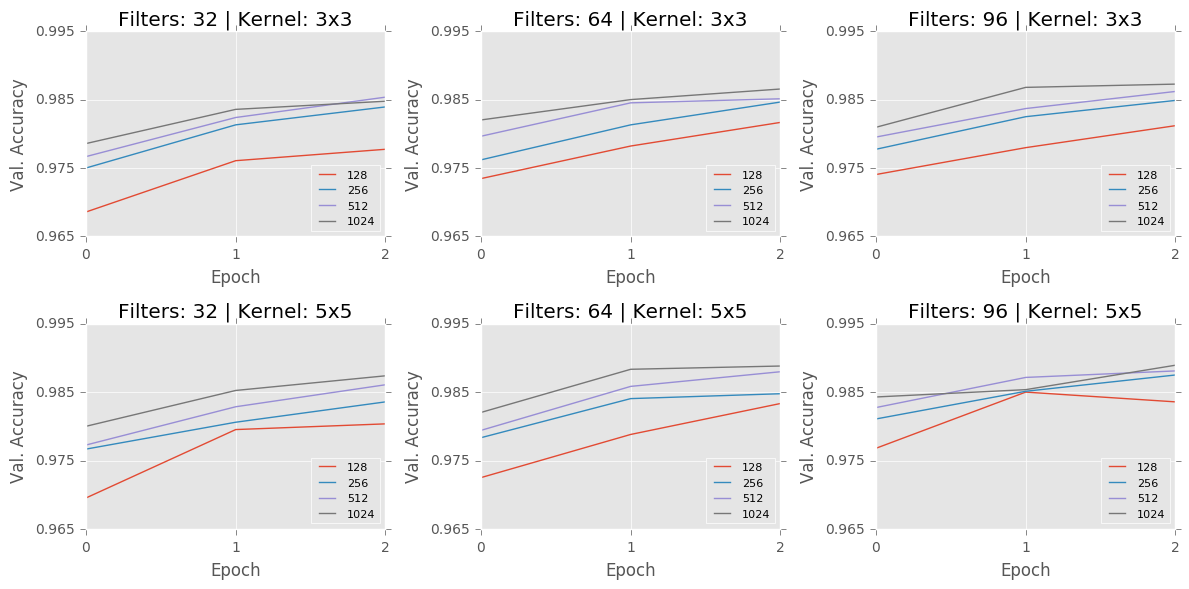

In [23]:
def plot_histories(histories):
    num_rows = len(kernel_size_range)
    num_cols = len(num_filters_range)
    plot_idx = 0
    plt.figure(figsize=(12,6))
    for i, kernel_size in enumerate(kernel_size_range):
        for j, num_filter in enumerate(num_filters_range):
            plot_idx += 1
            plot_history(histories, num_rows, num_cols, plot_idx, num_filter, kernel_size)
    plt.tight_layout()
    plt.show()

def plot_history(histories, num_rows, num_cols, plot_idx, num_filter, kernel_size):
    histories = filter_histories(histories, num_filter, kernel_size)
    configurations, results = sort_histories_by_dense_size(histories)
    dense_sizes = map(lambda configuration: get_dense_size(configuration), configurations)
    
    plt.subplot(num_rows, num_cols, plot_idx)
    for i, _ in enumerate(configurations):
        plt.plot(results[i]['val_acc'])
    plt.title("Filters: {} | Kernel: {}x{}".format(num_filter, kernel_size[0], kernel_size[1]))
    plt.ylabel('Val. Accuracy')
    plt.yticks(np.arange(0.965, 0.995, 0.01))
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, num_epochs, 1))
    plt.legend(dense_sizes, loc='lower right', prop={'size':8})

def filter_histories(histories, num_filter, kernel_size):
    configurations = histories.keys()
    configurations = filter(lambda configuration: get_num_filters(configuration) == num_filter and get_kernel_size(configuration) == kernel_size, configurations) 
    results = map(lambda configuration: histories[configuration], configurations)
    return dict(zip(configurations, results))

def sort_histories_by_dense_size(histories):
    sorted_configurations = sorted(histories.keys(), key=lambda configuration: get_dense_size(configuration))
    sorted_results = map(lambda configuration: histories[configuration], sorted_configurations)
    return sorted_configurations, sorted_results

def get_num_filters(configuration):
    return int(configuration[1:-1].split(",")[0])

def get_kernel_size(configuration):
    return int(configuration[1:-1].split(",")[1].strip()[1:]), int(configuration[1:-1].split(",")[2].strip()[:-1])

def get_dense_size(configuration):
    return int(configuration[1:-1].split(",")[-1])

plot_histories(histories)

We can make two main observations here:
1. _The models are not complex enough_: All 3 parameters we varied have a positive impact on validation accuracy. It seems to improve when we increase `num_filters`, `kernel_size` or `dense_size`. Thus, we could further increase model complexity and expect performance to increase as well.
2. _The models are close to convergence already_: All curves are not particularly steep. Especially the last epoch makes little difference for many of them. This suggestes we are close to convergence (or should change learning rate, which we ignore in this example)

# Train most promising model a little longer
In line with the first observation, we proceed with the most complex model and train it for another 6 epochs to verify it converged.

In [25]:
from keras.models import load_model

final_history_file = '../cache/notebook/final_history.p'
final_model_file = '../cache/notebook/final_model.h5'

if os.path.exists(final_history_file) and os.path.exists(final_model_file):
    print("Loading cached results...")
    final_history = pickle.load(open(final_history_file, "rb"))
    final_model = load_model(final_model_file)
else:
    print("Training best model some more...")
    final_model = load_model(best_model_file)
    result = final_model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=6,
                             verbose=1, validation_data=(X_val, y_val))
    final_history = result.history['val_acc']
    
    print("Saving results to cache...")
    final_model.save(final_model_file) 
    pickle.dump(final_history, open(final_history_file, "wb"))
    

print("Final accuracy: {:1.4f}".format(final_history[-1]))

Training best model some more...
Train on 134400 samples, validate on 8400 samples
Epoch 1/6
134400/134400 [==============================] - 2603s - loss: 0.1308 - acc: 0.9585 - val_loss: 0.0397 - val_acc: 0.9882
Epoch 2/6
134400/134400 [==============================] - 2608s - loss: 0.1085 - acc: 0.9659 - val_loss: 0.0342 - val_acc: 0.9904
Epoch 3/6
134400/134400 [==============================] - 2603s - loss: 0.0953 - acc: 0.9697 - val_loss: 0.0299 - val_acc: 0.9924
Epoch 4/6
134400/134400 [==============================] - 2604s - loss: 0.0852 - acc: 0.9730 - val_loss: 0.0314 - val_acc: 0.9914
Epoch 5/6
134400/134400 [==============================] - 2602s - loss: 0.0778 - acc: 0.9749 - val_loss: 0.0308 - val_acc: 0.9923
Epoch 6/6
134400/134400 [==============================] - 2602s - loss: 0.0716 - acc: 0.9773 - val_loss: 0.0308 - val_acc: 0.9923
Saving results to cache...
Final accuracy: 0.9923


# Visualize again to check progress
Let's look at the validation accuracies:

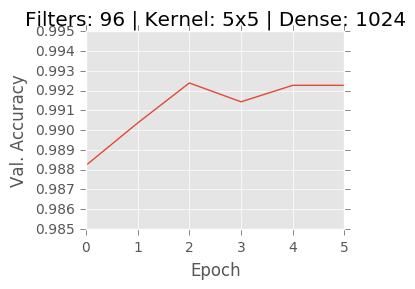

In [26]:
plt.figure(figsize=(4,3))
plt.plot(final_history)
plt.title("Filters: 96 | Kernel: 5x5 | Dense: 1024")
plt.ylabel('Val. Accuracy')
plt.yticks(np.arange(0.985, 0.995, 0.001))
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 6, 1))
plt.tight_layout()
plt.show()

We can see a slight increase followed by a mostly flat line with a few ups and downs. Further training the model will likely not improve anything (unless we decrease the learning rate, which may allow to squeeze out a bit more performance [when performance starts to plateau](http://caffe.berkeleyvision.org/tutorial/solver.html) - out of scope for this example)

### Visualize first layer weights

We can look at the weights of the first convolutional layer to verify that the network actually converges to something. A [rule of thumb](http://cs231n.github.io/neural-networks-3/#vis) is to aim for clear structure. Noisy pictures are a problem as they are an indicator that the network is not converging.

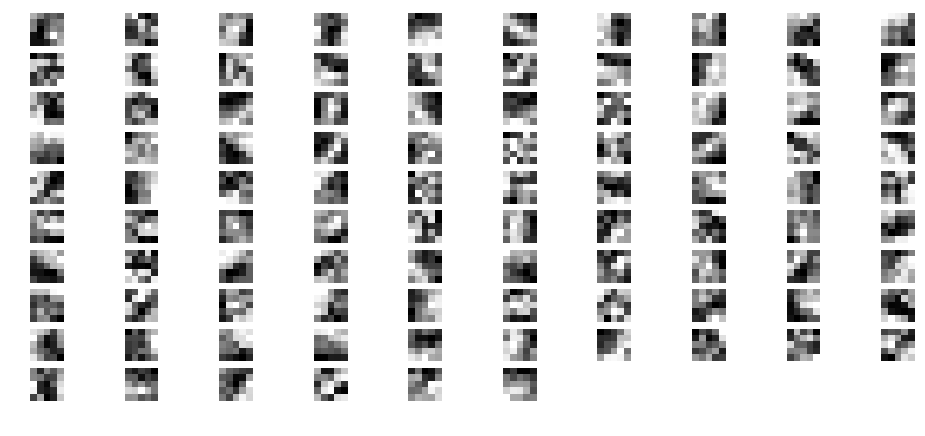

In [27]:
final_first_conv_layer = final_model.layers[0]

# will work only with first convolutional layers
def visualize_weights(model, layer):
    weights = layer.get_weights()[0] # ignore bias
    
    num_filters = weights.shape[3]
    num_cols = 10
    num_rows = (num_filters / num_cols) + 1
    plt.figure(figsize=(12, 5))
    for i in range(num_filters):
        current_weights = weights[:,:,:,i].squeeze()
        plt.subplot(num_rows, num_cols, i+1)
        plt.axis('off')
        plt.imshow(current_weights, cmap=cm.binary, interpolation='nearest')
    plt.show()

visualize_weights(final_model, final_first_conv_layer)

Most weights have relatively smooth features (althoigh they still look pixelated given the small kernel size). They do not look like random noise. Compare them with an untrained model below:

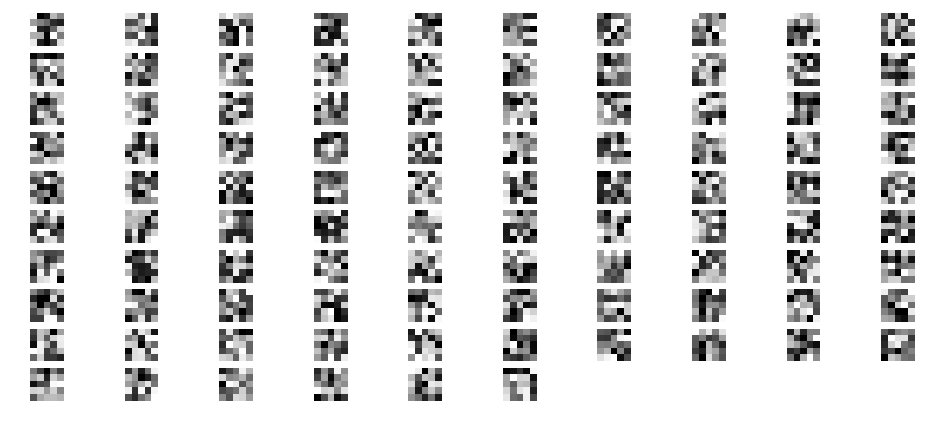

In [28]:
untrained_model = build_model(96, (5, 5), (2, 2), 1024)
visualize_weights(untrained_model, untrained_model.layers[0])

### Visualize activations - first and second layer

Besides plotting weights, we can also visualize the activations of convolutional layers given an exemplary input image. Different filters should be activated for different features of the example image.

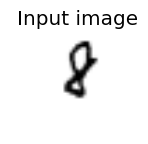

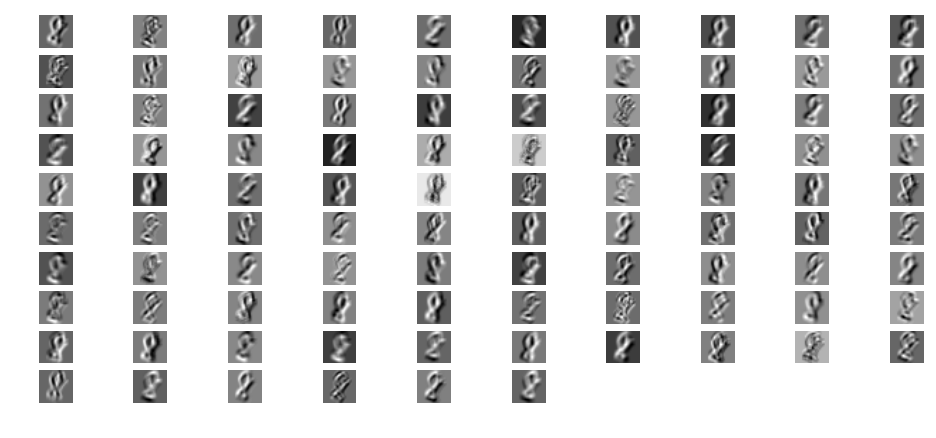

In [29]:
def visualize_activations(model, layer, image):
    conv_layer_out = K.function(model.inputs, [layer.output])
    output = conv_layer_out([np.expand_dims(image, 0)])[0].squeeze()
    
    num_filters = output.shape[2]
    num_cols = 10
    num_rows = (num_filters / num_cols) + 1
    plt.figure(figsize=(12, 5))
    for i in xrange(num_filters):
        plt.subplot(num_rows, num_cols, i+1)
        plt.axis('off')
        plt.imshow(output[:,:,i], cmap=cm.binary)
    plt.show()

image = X_train[0]
plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(image.squeeze(), cmap=cm.binary)
plt.title("Input image")
plt.show()

visualize_activations(final_model, final_first_conv_layer, image)

In the images, we can see how different filters highlight either on the holes of the 8 or on different kinds of it's edges. They appear to be sufficielty diverse (some redundancy is expected).

# Visualize model mistakes

It can be very interesting to visualize those digits the model cannot classify correctly. This will give hint's as to what kind of data should be collected in the future to achieve better performance on those kinds of images.

In [30]:
predictions_dummies = final_model.predict_proba(X_val)

8400/8400 [==============================] - 64s    


Number of mistakes: 65


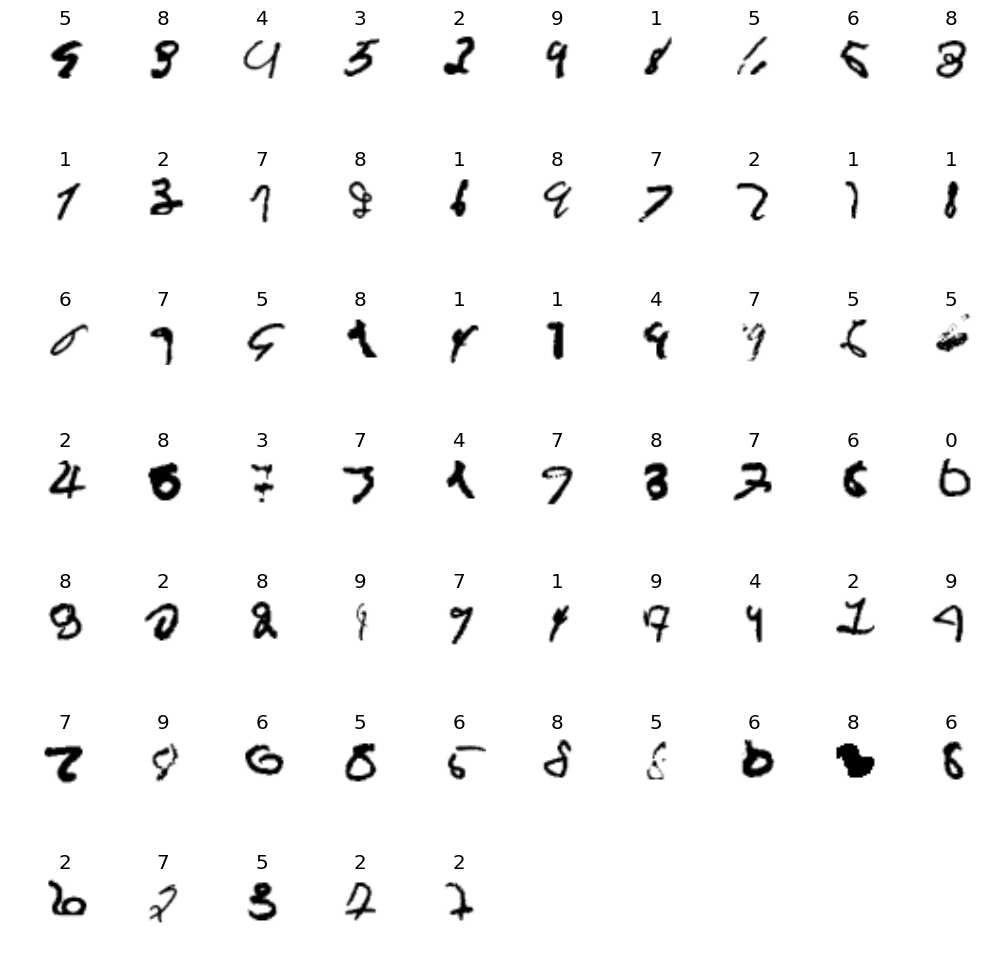

In [31]:
predictions = np.argmax(predictions_dummies, axis=1)
mistakes_idx = np.argwhere(predictions != validation_labels).flatten()
print("Number of mistakes: {}".format(len(mistakes_idx)))
display_multiple(validation_images, predictions, mistakes_idx)

Based on a quick visual inspection, we can see that it will be hard to avoid all mistakes. Some numbers are hard to classify even when taking a close look. In general, the images suggest that the following things may help improving results:
- _Collect more challenging data_: for instance, there are a lot of digits written with very thick pens
- _Apply more advanced transformations_: some digits look like parts of the numbers are missing (e.g., if someone writes an 8 but does not finish it properly). Such mistakes could be simulated by randomly removing parts of the images.

These ideas are not further pursued here.

# Prepare predictions for test set

Let's quickly create a submission for kaggle:

In [32]:
num_test = test.shape[0]
X_test = test.reshape(num_test, *input_shape).astype('float32') / 255

test_predictions_dummies = final_model.predict_proba(X_test)
test_predictions = np.argmax(test_predictions_dummies, axis=1)

print("Predictions: {}".format(test_predictions.shape))

28000/28000 [==============================] - 195s   
Predictions: (28000,)


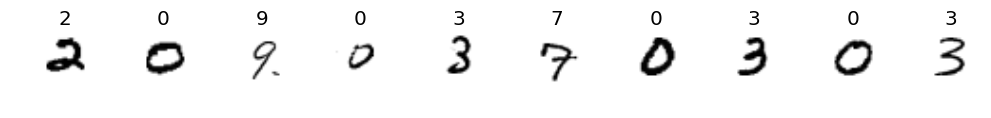

In [33]:
# verify predictions are reasonable
display_multiple(test, test_predictions, range(10))

In [34]:
submission = pd.Series(data=test_predictions, index=pd.Index(data=np.arange(num_test) + 1, name="ImageId"), name="Label")
submission.to_csv('../cache/notebook/submission.csv', header=True)

# Test the server
To use the REST server, first launch it with `bin/deploy_flask.sh`. Then, restart the development docker container with the additional option `--link server_flask:server_flask` to make the server available. You will be able to use the model remotely as follows:

In [ ]:
import urllib2, json, base64

def predict_remote(image):
    request_data = {"image": base64.b64encode(image.flatten())}
    req = urllib2.Request('http://server_flask:5000/predict')
    req.add_header('Content-Type', 'application/json')
    response = urllib2.urlopen(req, json.dumps(request_data))
    return json.loads(response.read())['number']

print("Predicting that {} is a {}".format(np.argwhere(y_train[0])[0][0], predict_remote(X_train[0])))